In [1]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline 

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
class SerieAPredictor:
    def __init__(self):
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.team_encoder = LabelEncoder()
        self.data = None
        self.team_stats = {}
        # URLs for data (Last season and Current season)
        self.urls = [
            "https://www.football-data.co.uk/mmz4281/2324/I1.csv", 
            "https://www.football-data.co.uk/mmz4281/2425/I1.csv"
        ]
        
    def load_data(self):
        print("Downloading data from the internet...")
        dfs = []
        for url in self.urls:
            try:
                s = requests.get(url).content
                df = pd.read_csv(io.StringIO(s.decode('utf-8')))
                # Standard columns: FTHG (Full Time Home Goals), FTR (Full Time Result)
                cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
                if all(col in df.columns for col in cols):
                    df = df[cols].dropna()
                    dfs.append(df)
            except Exception as e:
                print(f"Error with URL {url}: {e}")
        
        self.data = pd.concat(dfs, ignore_index=True)
        print(f"Data loaded. Total matches: {len(self.data)}")

    def calculate_stats(self):
        """Calculates Attack and Defense strength for Home and Away matches."""
        # We focus on the last 380 matches (approx. one full season equivalent)
        recent_data = self.data.tail(380)
        
        teams = pd.concat([recent_data['HomeTeam'], recent_data['AwayTeam']]).unique()
        self.team_encoder.fit(teams)
        
        for team in teams:
            home_games = recent_data[recent_data['HomeTeam'] == team]
            away_games = recent_data[recent_data['AwayTeam'] == team]
            
            # Calculate averages (Default to 1.0 if no games played to avoid errors)
            att_h = home_games['FTHG'].mean() if len(home_games) > 0 else 1.0
            def_h = home_games['FTAG'].mean() if len(home_games) > 0 else 1.0
            att_a = away_games['FTAG'].mean() if len(away_games) > 0 else 1.0
            def_a = away_games['FTHG'].mean() if len(away_games) > 0 else 1.0
            
            # Store stats: [Home_Attack, Home_Defense, Away_Attack, Away_Defense]
            self.team_stats[team] = [att_h, def_h, att_a, def_a]
            
        print("Team statistics (Attack/Defense) calculated successfully.")

    def train_model(self):
        X, y = [], []
        for _, row in self.data.iterrows():
            h, a = row['HomeTeam'], row['AwayTeam']
            if h in self.team_stats and a in self.team_stats:
                # Features: Home Team Home Stats + Away Team Away Stats
                features = self.team_stats[h][:2] + self.team_stats[a][2:]
                X.append(features)
                
                # Target: 2=Home Win, 1=Draw, 0=Away Win
                res = 2 if row['FTR'] == 'H' else (1 if row['FTR'] == 'D' else 0)
                y.append(res)
        
        self.model.fit(X, y)
        print("Machine Learning Model trained successfully!")

    def get_current_standings(self):
        """Calculates points based on the last 200 matches (Current Season approximation)."""
        current_season = self.data.tail(200) 
        standings = {team: 0 for team in self.team_encoder.classes_}
        
        for _, row in current_season.iterrows():
            h, a, res = row['HomeTeam'], row['AwayTeam'], row['FTR']
            if h not in standings: standings[h] = 0
            if a not in standings: standings[a] = 0
            
            if res == 'H': standings[h] += 3
            elif res == 'D': 
                standings[h] += 1
                standings[a] += 1
            else: standings[a] += 3
        return standings

    def generate_remaining_fixtures(self):
        """Identifies matches that haven't been played yet."""
        played = set()
        current_season = self.data.tail(300) # Check recent history
        for _, row in current_season.iterrows():
            played.add(f"{row['HomeTeam']}-{row['AwayTeam']}")
            
        teams = self.team_encoder.classes_
        fixtures = []
        for h in teams:
            for a in teams:
                if h != a and f"{h}-{a}" not in played:
                    fixtures.append((h, a))
        return fixtures

    def simulate_season(self, n_simulations=1000):
        print(f"Starting Monte Carlo Simulation ({n_simulations} runs)...")
        fixtures = self.generate_remaining_fixtures()
        
        # Pre-calculate probabilities for speed
        match_probs = []
        for h, a in fixtures:
            if h in self.team_stats and a in self.team_stats:
                features = self.team_stats[h][:2] + self.team_stats[a][2:]
                probs = self.model.predict_proba([features])[0]
                match_probs.append({'h': h, 'a': a, 'probs': probs})
            
        wins = {t: 0 for t in self.team_encoder.classes_}
        base_standings = self.get_current_standings()
        
        for _ in range(n_simulations):
            temp_standings = base_standings.copy()
            for m in match_probs:
                # Random choice based on model probability: 0=Away, 1=Draw, 2=Home
                res = np.random.choice([0, 1, 2], p=m['probs']) 
                if res == 2: temp_standings[m['h']] += 3
                elif res == 1: 
                    temp_standings[m['h']] += 1
                    temp_standings[m['a']] += 1
                else: temp_standings[m['a']] += 3
            
            winner = max(temp_standings, key=temp_standings.get)
            wins[winner] += 1
            
        return wins

In [3]:
# Initialize
app = SerieAPredictor()

# 1. Load Data
app.load_data()

# 2. Process Statistics
app.calculate_stats()

# 3. Train AI
app.train_model()

# 4. Run Simulation
# Use 1000 for better accuracy, 100 for speed
results = app.simulate_season(n_simulations=500)

Data loaded. Total matches: 760
Team statistics (Attack/Defense) calculated successfully.
Machine Learning Model trained successfully!
Starting Monte Carlo Simulation (500 runs)...


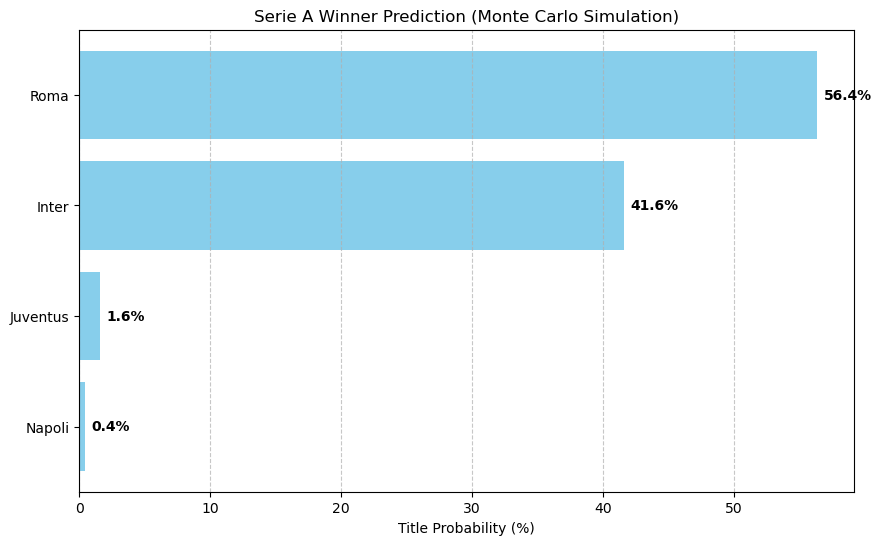

In [4]:
# Prepare data for plotting
df_res = pd.DataFrame(list(results.items()), columns=['Team', 'Simulated_Wins'])
df_res['Probability (%)'] = (df_res['Simulated_Wins'] / 500) * 100

# Filter teams with > 0% chance and sort
df_final = df_res[df_res['Probability (%)'] > 0].sort_values('Probability (%)', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(df_final['Team'], df_final['Probability (%)'], color='skyblue')

plt.xlabel('Title Probability (%)')
plt.title('Serie A Winner Prediction (Monte Carlo Simulation)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', va='center', fontweight='bold')

plt.show()

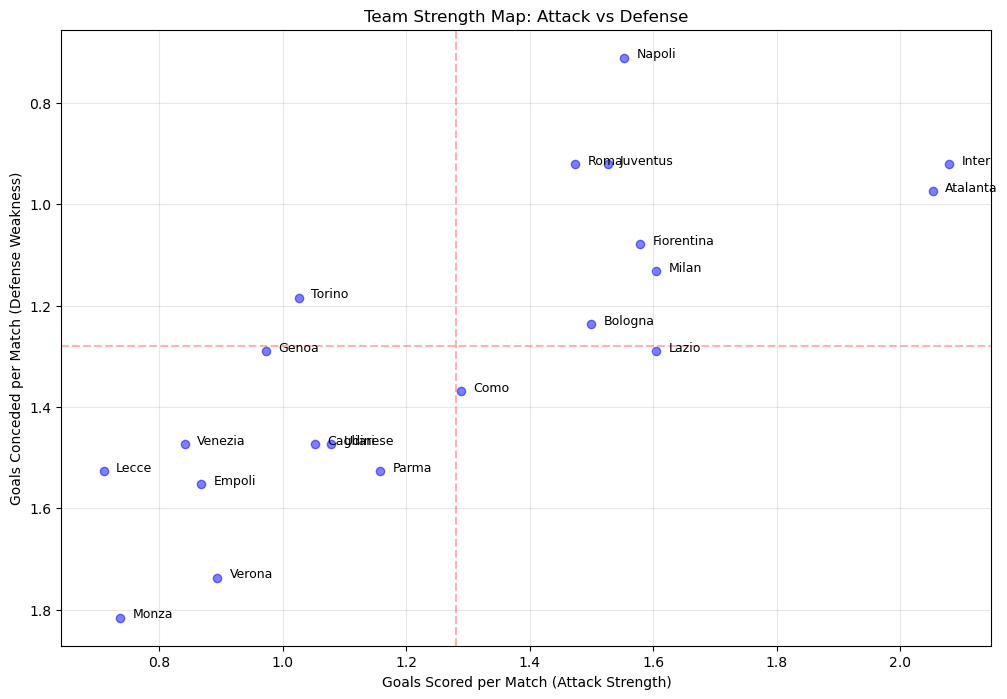

In [5]:
def plot_team_strength():
    teams = []
    attacks = []
    defenses = []
    
    for team, stats in app.team_stats.items():
        # stats = [Att_Home, Def_Home, Att_Away, Def_Away]
        avg_att = (stats[0] + stats[2]) / 2
        avg_def = (stats[1] + stats[3]) / 2
        
        teams.append(team)
        attacks.append(avg_att)
        defenses.append(avg_def)
        
    plt.figure(figsize=(12, 8))
    plt.scatter(attacks, defenses, color='blue', alpha=0.5)
    
    for i, team in enumerate(teams):
        plt.text(attacks[i]+0.02, defenses[i], team, fontsize=9)
        
    plt.title('Team Strength Map: Attack vs Defense')
    plt.xlabel('Goals Scored per Match (Attack Strength)')
    plt.ylabel('Goals Conceded per Match (Defense Weakness)')
    
    # Invert Y axis because fewer conceded goals is better
    plt.gca().invert_yaxis()
    
    plt.axvline(x=sum(attacks)/len(attacks), color='red', linestyle='--', alpha=0.3)
    plt.axhline(y=sum(defenses)/len(defenses), color='red', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.show()

plot_team_strength()

In [6]:
def predict_match(home_team, away_team):
    if home_team not in app.team_stats or away_team not in app.team_stats:
        print("Error: Team not found! Check spelling (Case Sensitive).")
        return

    stats_h = app.team_stats[home_team] 
    stats_a = app.team_stats[away_team] 
    
    # Features: [Home_Att, Home_Def, Away_Att, Away_Def]
    features = [stats_h[0], stats_h[1], stats_a[2], stats_a[3]]
    
    probs = app.model.predict_proba([features])[0]
    
    print(f"\n--- PREDICTION: {home_team} vs {away_team} ---")
    print(f"Home Win ({home_team}): {probs[2]*100:.1f}%")
    print(f"Draw:                  {probs[1]*100:.1f}%")
    print(f"Away Win ({away_team}): {probs[0]*100:.1f}%")
    
    winner_idx = probs.argmax()
    outcomes = ["Away Win", "Draw", "Home Win"]
    print(f"Model Suggestion: {outcomes[winner_idx]}")

# --- TEST IT HERE ---
predict_match('Inter', 'Juventus')
predict_match('Milan', 'Roma')


--- PREDICTION: Inter vs Juventus ---
Home Win (Inter): 39.1%
Draw:                  58.9%
Away Win (Juventus): 2.0%
Model Suggestion: Draw

--- PREDICTION: Milan vs Roma ---
Home Win (Milan): 49.4%
Draw:                  49.6%
Away Win (Roma): 1.0%
Model Suggestion: Draw


In [7]:
def show_detailed_table():
    season_data = app.data.tail(200) # Approx current season
    table_data = {}
    
    for team in app.team_encoder.classes_:
        table_data[team] = {'Points': 0, 'Played': 0, 'W': 0, 'D': 0, 'L': 0, 'GD': 0}
        
    for _, row in season_data.iterrows():
        h, a, res, fthg, ftag = row['HomeTeam'], row['AwayTeam'], row['FTR'], row['FTHG'], row['FTAG']
        
        # Check if teams exist in our encoder list
        if h in table_data and a in table_data:
            table_data[h]['Played'] += 1
            table_data[a]['Played'] += 1
            
            table_data[h]['GD'] += (fthg - ftag)
            table_data[a]['GD'] += (ftag - fthg)
            
            if res == 'H':
                table_data[h]['Points'] += 3
                table_data[h]['W'] += 1
                table_data[a]['L'] += 1
            elif res == 'D':
                table_data[h]['Points'] += 1
                table_data[a]['Points'] += 1
                table_data[h]['D'] += 1
                table_data[a]['D'] += 1
            else: 
                table_data[a]['Points'] += 3
                table_data[a]['W'] += 1
                table_data[h]['L'] += 1

    df_table = pd.DataFrame.from_dict(table_data, orient='index')
    df_table = df_table.sort_values(by=['Points', 'GD'], ascending=False)
    
    return df_table

display(show_detailed_table())

,Points,Played,W,D,L,GD
Roma,49,20,15,4,1,21
Inter,41,21,12,5,4,14
Napoli,38,19,10,8,1,14
Juventus,38,20,11,5,4,8
Milan,36,21,11,3,7,9
Bologna,34,21,9,7,5,6
Atalanta,33,20,9,6,5,18
Fiorentina,33,20,10,3,7,6
Como,31,20,9,4,7,7
Lazio,30,20,7,9,4,4


In [8]:
def predict_goals_market():
    # Now we can safely call the function from the class
    fixtures = app.generate_remaining_fixtures()
    market_data = []

    print("--- GOALS PREDICTION (OVER/UNDER 2.5) ---")
    
    for h, a in fixtures:
        if h in app.team_stats and a in app.team_stats:
            stats_h = app.team_stats[h]
            stats_a = app.team_stats[a]
            
            # Expected Home Goals = (Home Attack + Away Defense) / 2
            exp_goals_home = (stats_h[0] + stats_a[3]) / 2
            # Expected Away Goals = (Away Attack + Home Defense) / 2
            exp_goals_away = (stats_a[2] + stats_h[1]) / 2
            
            total_exp = exp_goals_home + exp_goals_away
            
            market_data.append({
                'Match': f"{h} - {a}",
                'Exp_Goals': round(total_exp, 2),
                'Bet': 'Over 2.5' if total_exp > 2.5 else 'Under 2.5'
            })
    
    if market_data:
        df_goals = pd.DataFrame(market_data)
        return df_goals.sort_values(by='Exp_Goals', ascending=False).head(10)
    else:
        return "No remaining matches found."

display(predict_goals_market())

--- GOALS PREDICTION (OVER/UNDER 2.5) ---


,Match,Exp_Goals,Bet
30,Inter - Milan,3.13,Over 2.5
38,Lazio - Milan,3.08,Over 2.5
28,Inter - Atalanta,3.05,Over 2.5
37,Lazio - Empoli,3.03,Over 2.5
59,Parma - Milan,2.92,Over 2.5
1,Atalanta - Fiorentina,2.92,Over 2.5
31,Inter - Torino,2.89,Over 2.5
40,Lazio - Verona,2.84,Over 2.5
20,Fiorentina - Milan,2.84,Over 2.5
61,Roma - Empoli,2.84,Over 2.5


MODEL CONFUSION MATRIX:
X-Axis: Predicted | Y-Axis: Actual


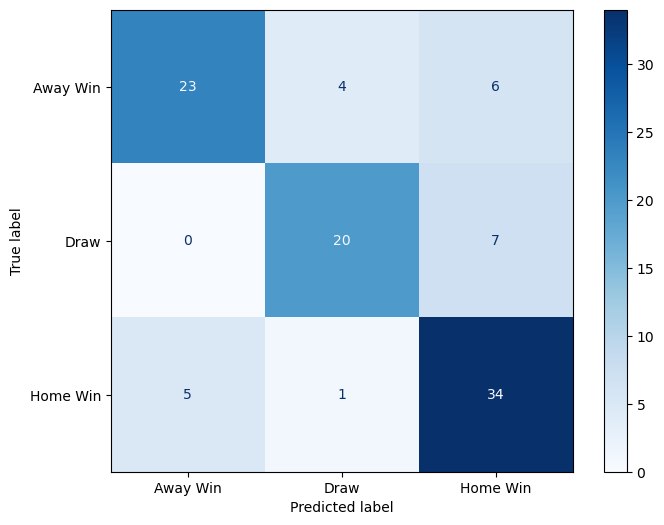

In [9]:
def evaluate_model_accuracy():
    X_test, y_test = [], []
    
    # Test on the last 100 matches
    test_data = app.data.tail(100)
    
    for _, row in test_data.iterrows():
        h, a = row['HomeTeam'], row['AwayTeam']
        if h in app.team_stats and a in app.team_stats:
            feats = app.team_stats[h][:2] + app.team_stats[a][2:]
            X_test.append(feats)
            res = 2 if row['FTR'] == 'H' else (1 if row['FTR'] == 'D' else 0)
            y_test.append(res)
            
    preds = app.model.predict(X_test)
    
    cm = confusion_matrix(y_test, preds, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Away Win', 'Draw', 'Home Win'])
    
    print("MODEL CONFUSION MATRIX:")
    print("X-Axis: Predicted | Y-Axis: Actual")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax)
    plt.show()

evaluate_model_accuracy()

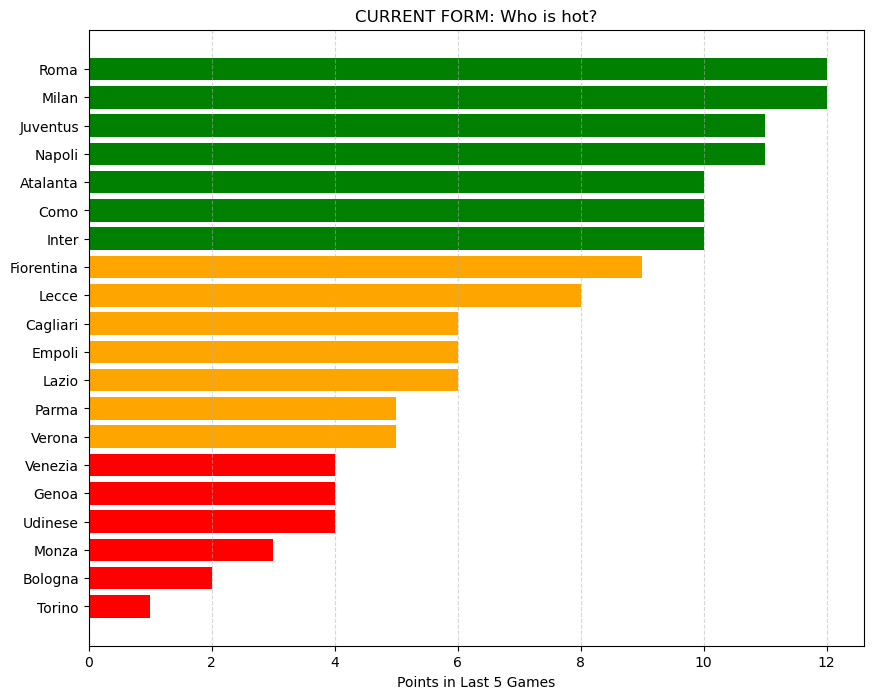

,Team,Form_Points,Recent_Results
15,Roma,12,W W L W W
11,Milan,12,W W W L W
8,Juventus,11,W D D W W
13,Napoli,11,W W D D W
0,Atalanta,10,D W W W L


In [10]:
def show_current_form():
    teams = app.team_encoder.classes_
    form_data = []
    season_data = app.data.tail(380) 
    
    for team in teams:
        matches = season_data[(season_data['HomeTeam'] == team) | (season_data['AwayTeam'] == team)]
        last_5 = matches.tail(5)
        points = 0
        res_str = ""
        
        for _, row in last_5.iterrows():
            if row['HomeTeam'] == team:
                if row['FTR'] == 'H': points += 3; res_str += "W "
                elif row['FTR'] == 'D': points += 1; res_str += "D "
                else: res_str += "L "
            else:
                if row['FTR'] == 'A': points += 3; res_str += "W "
                elif row['FTR'] == 'D': points += 1; res_str += "D "
                else: res_str += "L "
        
        form_data.append({'Team': team, 'Form_Points': points, 'Recent_Results': res_str})
        
    df_form = pd.DataFrame(form_data).sort_values('Form_Points', ascending=True)
    
    plt.figure(figsize=(10, 8))
    colors = ['red' if x < 5 else ('orange' if x < 10 else 'green') for x in df_form['Form_Points']]
    
    plt.barh(df_form['Team'], df_form['Form_Points'], color=colors)
    plt.xlabel('Points in Last 5 Games')
    plt.title('CURRENT FORM: Who is hot?')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()
    
    return df_form.sort_values('Form_Points', ascending=False).head(5)

display(show_current_form())